# Business Insights & Strategic Recommendations for IVI

## Executive Summary
This notebook delivers **data-driven strategic insights** for Bupa Arabia's Intelligent Value Index (IVI) initiative.

### Analysis Framework:
1. **Portfolio Segmentation** - Contract risk tiers, size analysis
2. **Demographic Deep Dive** - Nationality, gender, and workforce patterns
3. **Cost Driver Analysis** - What drives high costs and loss ratios?
4. **Provider Intelligence** - Network utilization and performance
5. **Service Experience Patterns** - Call behavior and complaint analysis
6. **Strategic Recommendations** - Actionable insights for retention

### Key Business Questions Answered:
- Which contract segments are most profitable/risky?
- What demographic factors correlate with high utilization?
- Which providers deliver best value?
- What are early warning signs of contract churn?
- Where should Bupa focus retention efforts?

In [1]:
# Import Libraries
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Color palette for Bupa Arabia theme
BUPA_COLORS = {
    'primary': '#0A2463',      # Deep blue
    'secondary': '#3E92CC',    # Light blue
    'accent': '#1E1B18',       # Dark
    'success': '#2E8B57',      # Green
    'warning': '#FF6B35',      # Orange
    'danger': '#D64045',       # Red
    'neutral': '#8B8C89',      # Gray
}

# Custom color palette for charts
CHART_PALETTE = ['#0A2463', '#3E92CC', '#2E8B57', '#FF6B35', '#D64045', '#8B8C89', '#5C4D7D', '#00A896']

# Polars config
pl.Config.set_tbl_rows(15)
pl.Config.set_fmt_str_lengths(50)

# Data paths
DATA_DIR = Path('/volume/data/processed')
OUTPUT_DIR = Path('/volume/data/insights')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print('Libraries loaded successfully.')
print(f'Output directory: {OUTPUT_DIR}')

Libraries loaded successfully.
Output directory: /volume/data/insights


In [2]:
# Load curated datasets
print('Loading curated datasets...')

df_contract = pl.read_parquet(DATA_DIR / 'contract_level.parquet')
df_member = pl.read_parquet(DATA_DIR / 'member_level.parquet')
dim_nationality = pl.read_parquet(DATA_DIR / 'dim_nationality.parquet')
dim_provider = pl.read_parquet(DATA_DIR / 'dim_provider.parquet')
dim_diagnosis = pl.read_parquet(DATA_DIR / 'dim_diagnosis.parquet')
dim_calls = pl.read_parquet(DATA_DIR / 'dim_calls.parquet')
df_provider_ref = pl.read_parquet(DATA_DIR / 'ref_provider.parquet')

print(f'Contract-level: {df_contract.shape}')
print(f'Member-level: {df_member.shape}')
print(f'Nationality dim: {dim_nationality.shape}')
print(f'Provider dim: {dim_provider.shape}')
print(f'Diagnosis dim: {dim_diagnosis.shape}')
print(f'Calls dim: {dim_calls.shape}')
print('\nAll datasets loaded.')

Loading curated datasets...
Contract-level: (133704, 54)
Member-level: (4201467, 19)
Nationality dim: (281578, 6)
Provider dim: (1135632, 10)
Diagnosis dim: (3256468, 5)
Calls dim: (191423, 4)

All datasets loaded.


---
## 1. Portfolio Overview & Contract Segmentation

Understanding the distribution of contracts by size, profitability, and risk is critical for strategic planning.

In [ ]:
# Portfolio summary statistics
print('=' * 70)
print('BUPA ARABIA PORTFOLIO OVERVIEW')
print('=' * 70)

portfolio_stats = df_contract.select([
    pl.len().alias('Total Contracts'),
    pl.col('TOTAL_MEMBERS').sum().alias('Total Members'),
    pl.col('TOTAL_WRITTEN_PREMIUM').sum().alias('Total Premium (SAR)'),
    pl.col('TOTAL_NET_BILLED').sum().alias('Total Claims (SAR)'),
    (pl.col('TOTAL_NET_BILLED').sum() / pl.col('TOTAL_EARNED').sum()).alias('Portfolio Loss Ratio'),
    pl.col('UTILIZATION_RATE').mean().alias('Avg Utilization Rate'),
]).to_pandas().T

portfolio_stats.columns = ['Value']

def format_value(x):
    """Format values appropriately based on magnitude."""
    if pd.isna(x):
        return 'N/A'
    elif isinstance(x, (int, float)):
        if x > 100:
            return f'{x:,.0f}'
        elif x < 2:
            return f'{x:.2%}'
        else:
            return f'{x:.2f}'
    return str(x)

portfolio_stats['Formatted'] = portfolio_stats['Value'].apply(format_value)
print(portfolio_stats[['Formatted']])

BUPA ARABIA PORTFOLIO OVERVIEW
                           Formatted
Total Contracts              133,704
Total Members              4,201,467
Total Premium (SAR)   69,386,332,785
Total Claims (SAR)    53,668,504,057
Portfolio Loss Ratio          15,495
Avg Utilization Rate          17.16%


In [4]:
# Contract size segmentation
def segment_contract_size(members):
    if members < 50:
        return 'Micro (<50)'
    elif members < 200:
        return 'Small (50-199)'
    elif members < 1000:
        return 'Medium (200-999)'
    elif members < 5000:
        return 'Large (1K-5K)'
    else:
        return 'Enterprise (5K+)'

df_contract = df_contract.with_columns([
    pl.col('TOTAL_MEMBERS').map_elements(segment_contract_size, return_dtype=pl.Utf8).alias('SIZE_SEGMENT'),
])

# Loss ratio risk tiers
df_contract = df_contract.with_columns([
    pl.when(pl.col('LOSS_RATIO') < 0.6).then(pl.lit('Low Risk'))
      .when(pl.col('LOSS_RATIO') < 0.85).then(pl.lit('Moderate'))
      .when(pl.col('LOSS_RATIO') < 1.0).then(pl.lit('Break-even'))
      .when(pl.col('LOSS_RATIO') < 1.3).then(pl.lit('Elevated'))
      .otherwise(pl.lit('High Risk')).alias('RISK_TIER'),
])

print('Segments added: SIZE_SEGMENT, RISK_TIER')

Segments added: SIZE_SEGMENT, RISK_TIER


In [5]:
# Contract size distribution analysis
size_analysis = df_contract.group_by('SIZE_SEGMENT').agg([
    pl.len().alias('Contract Count'),
    pl.col('TOTAL_MEMBERS').sum().alias('Total Members'),
    pl.col('TOTAL_WRITTEN_PREMIUM').sum().alias('Total Premium'),
    pl.col('TOTAL_NET_BILLED').sum().alias('Total Claims'),
    pl.col('LOSS_RATIO').mean().alias('Avg Loss Ratio'),
    pl.col('UTILIZATION_RATE').mean().alias('Avg Utilization'),
]).with_columns([
    (pl.col('Total Claims') / pl.col('Total Premium')).alias('Segment Loss Ratio'),
]).sort('Total Members', descending=True)

# Order segments logically
segment_order = ['Micro (<50)', 'Small (50-199)', 'Medium (200-999)', 'Large (1K-5K)', 'Enterprise (5K+)']
size_analysis = size_analysis.with_columns([
    pl.col('SIZE_SEGMENT').map_elements(
        lambda x: segment_order.index(x) if x in segment_order else 99,
        return_dtype=pl.Int64
    ).alias('order')
]).sort('order').drop('order')

print('CONTRACT SIZE SEGMENTATION ANALYSIS')
print('=' * 70)
size_analysis

CONTRACT SIZE SEGMENTATION ANALYSIS


SIZE_SEGMENT,Contract Count,Total Members,Total Premium,Total Claims,Avg Loss Ratio,Avg Utilization,Segment Loss Ratio
str,u32,u32,f64,f64,f64,f64,f64
"""Micro (<50)""",125186,400549,3.1505e9,2.2456e9,2773.504615,0.142955,0.712797
"""Small (50-199)""",5511,538284,5.9008e9,4.1134e9,9230.246095,0.591599,0.697092
"""Medium (200-999)""",2384,1004863,1.4165e10,1.0133e10,11979.348714,0.595576,0.715341
"""Large (1K-5K)""",513,1035865,1.7201e10,1.3298e10,15050.307842,0.596395,0.773118
"""Enterprise (5K+)""",110,1221906,2.8969e10,2.3878e10,18028.213256,0.609947,0.824266


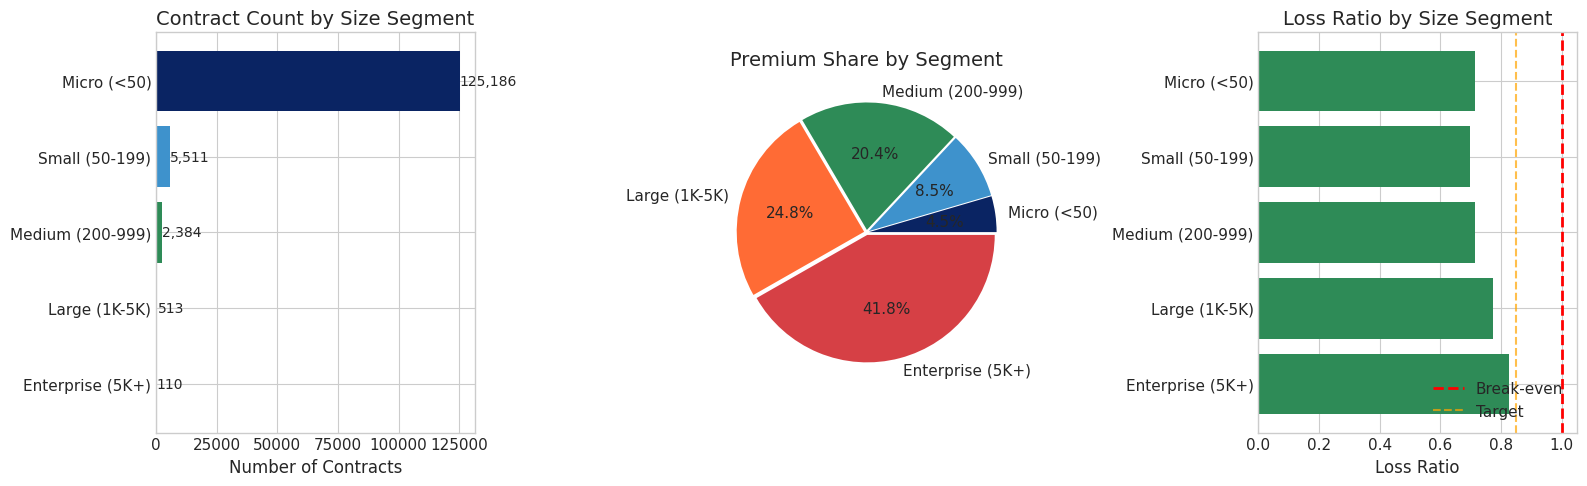


KEY INSIGHT: Enterprise contracts generate most premium but need careful loss ratio monitoring.


In [6]:
# Visualization: Contract Size vs Premium Contribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

size_df = size_analysis.to_pandas()

# 1. Contract count by segment
ax = axes[0]
bars = ax.barh(size_df['SIZE_SEGMENT'], size_df['Contract Count'], color=CHART_PALETTE[:5])
ax.set_xlabel('Number of Contracts')
ax.set_title('Contract Count by Size Segment')
ax.invert_yaxis()
for bar, val in zip(bars, size_df['Contract Count']):
    ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, f'{val:,.0f}', va='center', fontsize=10)

# 2. Premium contribution (pie)
ax = axes[1]
wedges, texts, autotexts = ax.pie(
    size_df['Total Premium'], 
    labels=size_df['SIZE_SEGMENT'],
    autopct='%1.1f%%',
    colors=CHART_PALETTE[:5],
    explode=[0.02]*len(size_df)
)
ax.set_title('Premium Share by Segment')

# 3. Loss ratio by segment
ax = axes[2]
colors = [BUPA_COLORS['success'] if lr < 0.85 else BUPA_COLORS['warning'] if lr < 1.0 else BUPA_COLORS['danger'] 
          for lr in size_df['Segment Loss Ratio']]
bars = ax.barh(size_df['SIZE_SEGMENT'], size_df['Segment Loss Ratio'], color=colors)
ax.axvline(1.0, color='red', linestyle='--', linewidth=2, label='Break-even')
ax.axvline(0.85, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Target')
ax.set_xlabel('Loss Ratio')
ax.set_title('Loss Ratio by Size Segment')
ax.legend(loc='lower right')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'contract_size_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nKEY INSIGHT: Enterprise contracts generate most premium but need careful loss ratio monitoring.')

In [7]:
# Risk tier distribution
risk_analysis = df_contract.group_by('RISK_TIER').agg([
    pl.len().alias('Contract Count'),
    pl.col('TOTAL_MEMBERS').sum().alias('Total Members'),
    pl.col('TOTAL_WRITTEN_PREMIUM').sum().alias('Total Premium'),
    pl.col('TOTAL_NET_BILLED').sum().alias('Total Claims'),
]).with_columns([
    (pl.col('Contract Count') / pl.col('Contract Count').sum() * 100).alias('% of Contracts'),
    (pl.col('Total Premium') / pl.col('Total Premium').sum() * 100).alias('% of Premium'),
])

# Order by risk level
risk_order = ['Low Risk', 'Moderate', 'Break-even', 'Elevated', 'High Risk']
risk_analysis = risk_analysis.with_columns([
    pl.col('RISK_TIER').map_elements(
        lambda x: risk_order.index(x) if x in risk_order else 99,
        return_dtype=pl.Int64
    ).alias('order')
]).sort('order').drop('order')

print('RISK TIER DISTRIBUTION')
print('=' * 70)
risk_analysis

RISK TIER DISTRIBUTION


RISK_TIER,Contract Count,Total Members,Total Premium,Total Claims,% of Contracts,% of Premium
str,u32,u32,f64,f64,f64,f64
"""Low Risk""",102357,124573,2.3323e8,703012.8952,76.554927,0.336136
"""Elevated""",2,168,3.6385e6,165.45606,0.001496,0.005244
"""High Risk""",31345,4076726,6.9149e10,5.3668e10,23.443577,99.65862


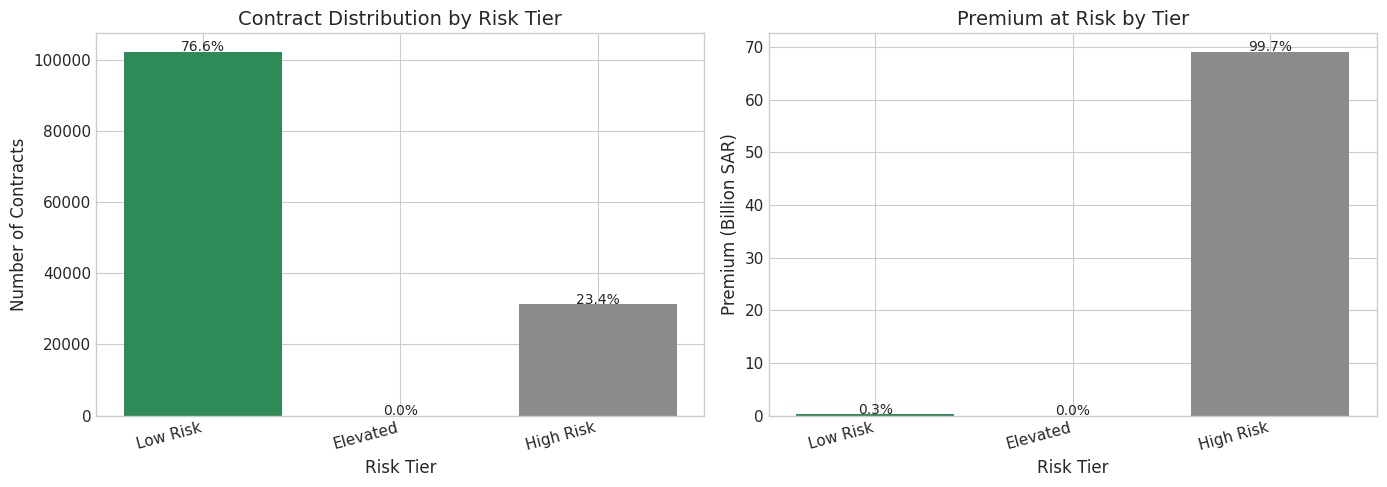


CRITICAL: 99.7% of premium (69.15B SAR) is in Elevated/High Risk tiers!


In [8]:
# Risk tier visualization
risk_df = risk_analysis.to_pandas()
risk_colors = [BUPA_COLORS['success'], BUPA_COLORS['secondary'], BUPA_COLORS['neutral'], 
               BUPA_COLORS['warning'], BUPA_COLORS['danger']]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Contracts by risk tier
ax = axes[0]
bars = ax.bar(risk_df['RISK_TIER'], risk_df['Contract Count'], color=risk_colors)
ax.set_xlabel('Risk Tier')
ax.set_ylabel('Number of Contracts')
ax.set_title('Contract Distribution by Risk Tier')
for bar, val in zip(bars, risk_df['% of Contracts']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, f'{val:.1f}%', ha='center', fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=15, ha='right')

# 2. Premium at risk
ax = axes[1]
bars = ax.bar(risk_df['RISK_TIER'], risk_df['Total Premium']/1e9, color=risk_colors)
ax.set_xlabel('Risk Tier')
ax.set_ylabel('Premium (Billion SAR)')
ax.set_title('Premium at Risk by Tier')
for bar, val in zip(bars, risk_df['% of Premium']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, f'{val:.1f}%', ha='center', fontsize=10)
plt.setp(ax.get_xticklabels(), rotation=15, ha='right')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'risk_tier_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate premium at elevated/high risk
high_risk_premium = risk_df[risk_df['RISK_TIER'].isin(['Elevated', 'High Risk'])]['Total Premium'].sum()
total_premium = risk_df['Total Premium'].sum()
print(f'\nCRITICAL: {high_risk_premium/total_premium*100:.1f}% of premium ({high_risk_premium/1e9:.2f}B SAR) is in Elevated/High Risk tiers!')

---
## 2. Demographic Analysis: Nationality Insights

Understanding nationality-based patterns is crucial for:
- Tailored wellness programs
- Cultural-specific health interventions
- Risk-adjusted pricing

In [9]:
# Aggregate nationality data across all contracts
nationality_summary = dim_nationality.group_by('NATIONALITY').agg([
    pl.col('MEMBER_COUNT').sum().alias('Total Members'),
    pl.col('TOTAL_BILLED').sum().alias('Total Claims'),
    pl.col('CLAIM_COUNT').sum().alias('Total Claim Lines'),
    pl.col('CONTRACT_NO').n_unique().alias('Contracts'),
]).with_columns([
    (pl.col('Total Claims') / pl.col('Total Members')).alias('Cost per Member'),
    (pl.col('Total Claim Lines') / pl.col('Total Members')).alias('Claims per Member'),
]).sort('Total Members', descending=True)

# Filter to top nationalities (with meaningful data)
top_nationalities = nationality_summary.filter(pl.col('Total Members') > 1000)

print('TOP NATIONALITIES BY MEMBER COUNT')
print('=' * 70)
top_nationalities.head(15)

TOP NATIONALITIES BY MEMBER COUNT


NATIONALITY,Total Members,Total Claims,Total Claim Lines,Contracts,Cost per Member,Claims per Member
str,u32,f64,u32,u32,f64,f64
"""Saudi Arabia""",2025854,2.0405e10,26679855,24229,10072.319307,13.169683
"""India""",413273,8.8211e8,2694854,16784,2134.451371,6.52076
"""Egypt""",333093,1.8547e9,3611042,20846,5567.999185,10.840942
"""Pakistan""",258732,8.0967e8,2065534,14586,3129.39298,7.983295
"""Yemen""",201064,9.4555e8,2388083,15578,4702.749994,11.877228
"""Bangladesh""",192752,2.5648e8,1091394,12439,1330.60291,5.662167
"""Philippines""",114905,3.2970e8,585272,7922,2869.355929,5.093529
"""Sudan""",84346,4.0584e8,800208,10751,4811.587796,9.487207
"""Nepal""",83743,5.4215e7,257456,4243,647.402261,3.074358


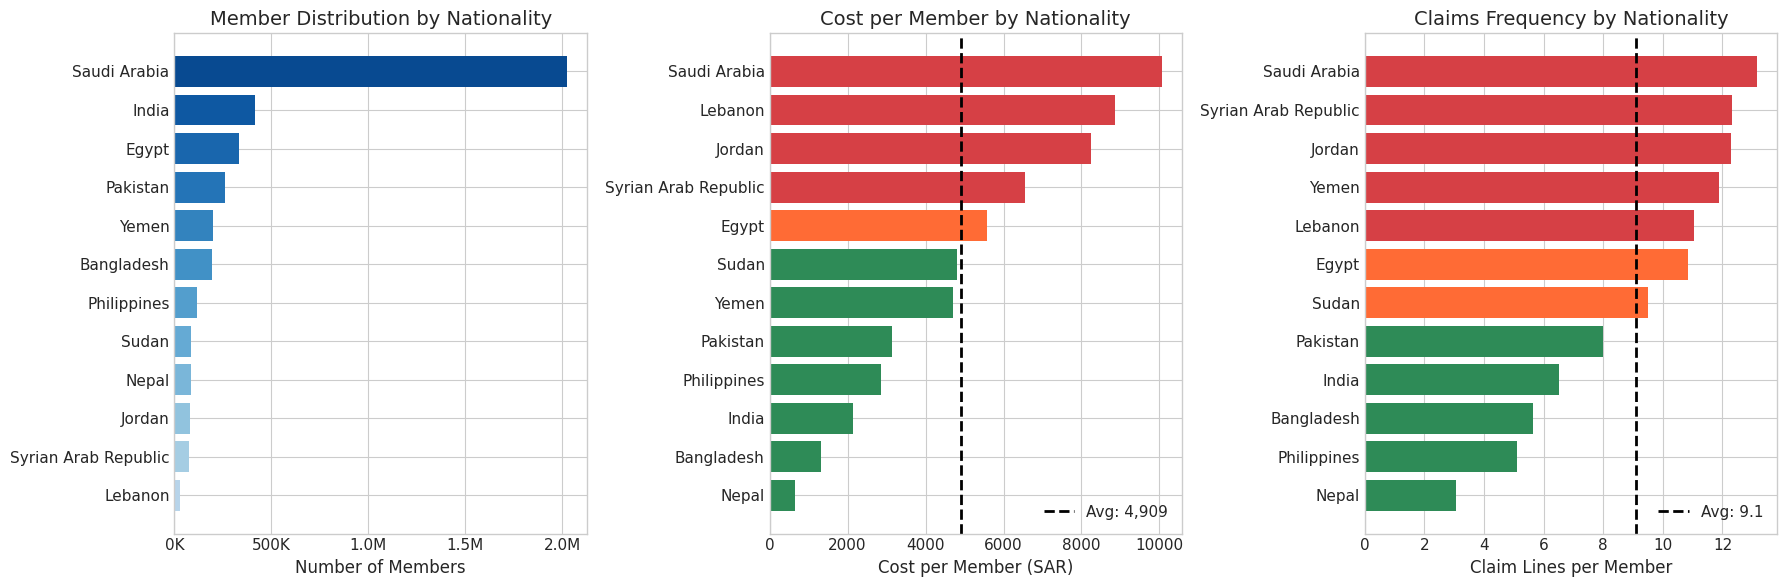

In [10]:
# Nationality cost analysis visualization
nat_df = top_nationalities.head(12).to_pandas()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Member distribution
ax = axes[0]
nat_sorted = nat_df.sort_values('Total Members', ascending=True)
colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(nat_sorted)))
ax.barh(nat_sorted['NATIONALITY'], nat_sorted['Total Members'], color=colors)
ax.set_xlabel('Number of Members')
ax.set_title('Member Distribution by Nationality')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K'))

# 2. Cost per member comparison
ax = axes[1]
nat_sorted = nat_df.sort_values('Cost per Member', ascending=True)
avg_cost = nat_df['Cost per Member'].mean()
colors = [BUPA_COLORS['danger'] if c > avg_cost * 1.2 else BUPA_COLORS['warning'] if c > avg_cost else BUPA_COLORS['success']
          for c in nat_sorted['Cost per Member']]
ax.barh(nat_sorted['NATIONALITY'], nat_sorted['Cost per Member'], color=colors)
ax.axvline(avg_cost, color='black', linestyle='--', linewidth=2, label=f'Avg: {avg_cost:,.0f}')
ax.set_xlabel('Cost per Member (SAR)')
ax.set_title('Cost per Member by Nationality')
ax.legend()

# 3. Claims frequency
ax = axes[2]
nat_sorted = nat_df.sort_values('Claims per Member', ascending=True)
avg_claims = nat_df['Claims per Member'].mean()
colors = [BUPA_COLORS['danger'] if c > avg_claims * 1.2 else BUPA_COLORS['warning'] if c > avg_claims else BUPA_COLORS['success']
          for c in nat_sorted['Claims per Member']]
ax.barh(nat_sorted['NATIONALITY'], nat_sorted['Claims per Member'], color=colors)
ax.axvline(avg_claims, color='black', linestyle='--', linewidth=2, label=f'Avg: {avg_claims:.1f}')
ax.set_xlabel('Claim Lines per Member')
ax.set_title('Claims Frequency by Nationality')
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'nationality_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [11]:
# Nationality diversity impact on contracts
diversity_impact = df_contract.select([
    'CONTRACT_NO', 'UNIQUE_NATIONALITIES', 'TOTAL_MEMBERS', 'LOSS_RATIO', 
    'UTILIZATION_RATE', 'COST_PER_MEMBER'
]).with_columns([
    pl.when(pl.col('UNIQUE_NATIONALITIES') == 1).then(pl.lit('Single Nationality'))
      .when(pl.col('UNIQUE_NATIONALITIES') <= 5).then(pl.lit('Low Diversity (2-5)'))
      .when(pl.col('UNIQUE_NATIONALITIES') <= 15).then(pl.lit('Medium (6-15)'))
      .otherwise(pl.lit('High Diversity (15+)')).alias('DIVERSITY_LEVEL'),
])

diversity_stats = diversity_impact.group_by('DIVERSITY_LEVEL').agg([
    pl.len().alias('Contract Count'),
    pl.col('LOSS_RATIO').mean().alias('Avg Loss Ratio'),
    pl.col('UTILIZATION_RATE').mean().alias('Avg Utilization'),
    pl.col('COST_PER_MEMBER').mean().alias('Avg Cost/Member'),
])

print('NATIONALITY DIVERSITY IMPACT ON CONTRACT PERFORMANCE')
print('=' * 70)
diversity_stats

NATIONALITY DIVERSITY IMPACT ON CONTRACT PERFORMANCE


DIVERSITY_LEVEL,Contract Count,Avg Loss Ratio,Avg Utilization,Avg Cost/Member
str,u32,f64,f64,f64
"""Single Nationality""",108215,1798.162742,0.070878,1371.435498
"""Medium (6-15)""",10304,8866.427764,0.58668,7199.909721
"""High Diversity (15+)""",1669,13340.705061,0.603492,10683.118347
"""Low Diversity (2-5)""",13516,9479.211614,0.608665,7543.283482


---
## 3. Gender Analysis

Understanding gender-based healthcare utilization patterns.

In [ ]:
# Gender analysis from member-level data
# Calculate average claims for utilizers using when/then instead of filter
gender_summary = df_member.group_by('GENDER').agg([
    pl.len().alias('Member Count'),
    pl.col('TOTAL_BILLED').sum().alias('Total Claims'),
    pl.col('TOTAL_BILLED').mean().alias('Avg Claims'),
    pl.col('UNIQUE_CLAIMS').sum().alias('Total Claim Count'),
    pl.col('IS_UTILIZER').mean().alias('Utilization Rate'),
    # Average claims for utilizers only
    pl.when(pl.col('IS_UTILIZER') == 1)
      .then(pl.col('TOTAL_BILLED'))
      .otherwise(None)
      .mean()
      .alias('Avg Claims (Utilizers)'),
]).filter(pl.col('GENDER').is_not_null())

print('GENDER-BASED HEALTHCARE UTILIZATION')
print('=' * 70)
gender_summary

GENDER-BASED HEALTHCARE UTILIZATION


GENDER,Member Count,Total Claims,Avg Claims,Total Claim Count,Utilization Rate,Avg Claims (Utilizers)
str,u32,f64,f64,u32,f64,f64
"""IHC""",32,22121.82049,691.30689,17,0.09375,7373.940163
"""F""",1503615,1.3742e10,9139.469447,4293070,0.334975,27284.058016
"""M""",2697820,1.4022e10,5197.450828,5121329,0.291456,17832.730453


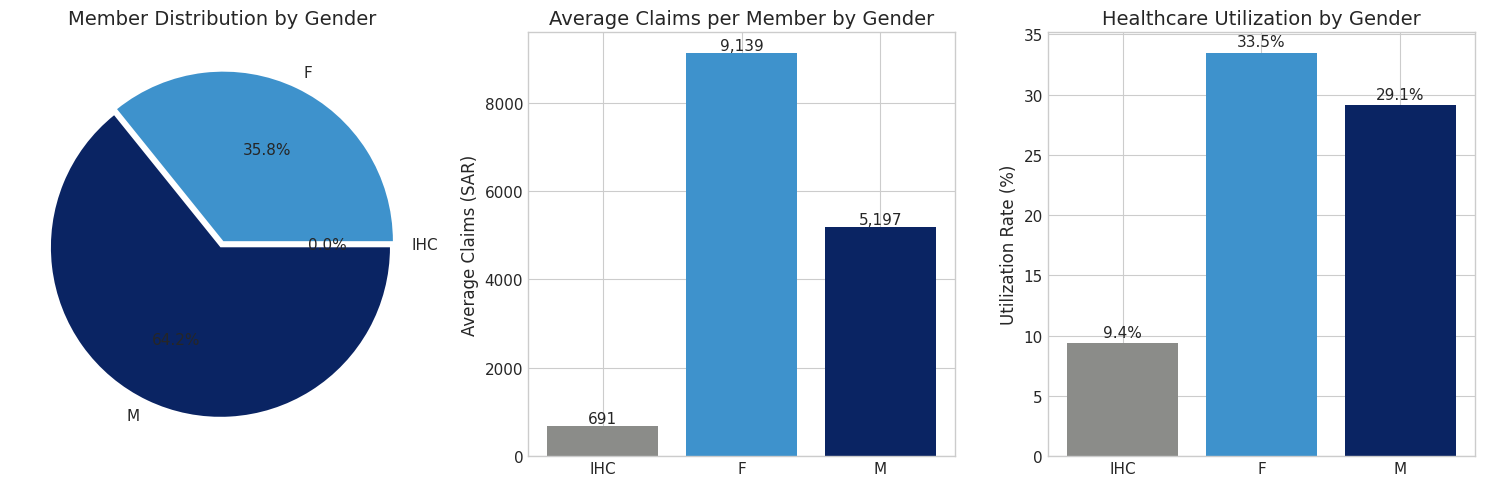

In [13]:
# Gender visualization
gender_df = gender_summary.to_pandas()

if len(gender_df) >= 2:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    gender_colors = {'M': BUPA_COLORS['primary'], 'F': BUPA_COLORS['secondary'], 
                     'Male': BUPA_COLORS['primary'], 'Female': BUPA_COLORS['secondary']}
    colors = [gender_colors.get(g, BUPA_COLORS['neutral']) for g in gender_df['GENDER']]
    
    # 1. Member distribution
    ax = axes[0]
    ax.pie(gender_df['Member Count'], labels=gender_df['GENDER'], autopct='%1.1f%%', 
           colors=colors, explode=[0.02]*len(gender_df))
    ax.set_title('Member Distribution by Gender')
    
    # 2. Average claims
    ax = axes[1]
    bars = ax.bar(gender_df['GENDER'], gender_df['Avg Claims'], color=colors)
    ax.set_ylabel('Average Claims (SAR)')
    ax.set_title('Average Claims per Member by Gender')
    for bar, val in zip(bars, gender_df['Avg Claims']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, f'{val:,.0f}', ha='center')
    
    # 3. Utilization rate
    ax = axes[2]
    bars = ax.bar(gender_df['GENDER'], gender_df['Utilization Rate'] * 100, color=colors)
    ax.set_ylabel('Utilization Rate (%)')
    ax.set_title('Healthcare Utilization by Gender')
    for bar, val in zip(bars, gender_df['Utilization Rate']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val*100:.1f}%', ha='center')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'gender_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print('Insufficient gender data for visualization.')

In [14]:
# Gender ratio impact on contract performance
gender_ratio_analysis = df_contract.with_columns([
    pl.when(pl.col('MALE_RATIO') > 0.7).then(pl.lit('Male Dominant (>70%)'))
      .when(pl.col('MALE_RATIO') > 0.55).then(pl.lit('Male Majority (55-70%)'))
      .when(pl.col('MALE_RATIO') >= 0.45).then(pl.lit('Balanced (45-55%)'))
      .when(pl.col('MALE_RATIO') >= 0.3).then(pl.lit('Female Majority (30-45%)'))
      .otherwise(pl.lit('Female Dominant (<30%)')).alias('GENDER_MIX'),
]).group_by('GENDER_MIX').agg([
    pl.len().alias('Contract Count'),
    pl.col('TOTAL_MEMBERS').sum().alias('Total Members'),
    pl.col('LOSS_RATIO').mean().alias('Avg Loss Ratio'),
    pl.col('UTILIZATION_RATE').mean().alias('Avg Utilization'),
    pl.col('COST_PER_MEMBER').mean().alias('Avg Cost/Member'),
]).sort('Contract Count', descending=True)

print('GENDER MIX IMPACT ON CONTRACT PERFORMANCE')
print('=' * 70)
gender_ratio_analysis

GENDER MIX IMPACT ON CONTRACT PERFORMANCE


GENDER_MIX,Contract Count,Total Members,Avg Loss Ratio,Avg Utilization,Avg Cost/Member
str,u32,u32,f64,f64,f64
"""Male Dominant (>70%)""",73840,1616731,2320.418689,0.145802,1817.414067
"""Female Dominant (<30%)""",45456,83541,1636.867532,0.059589,1242.517467
"""Male Majority (55-70%)""",7531,1261808,11248.02355,0.64135,8895.323036
"""Balanced (45-55%)""",4575,1078479,15879.841971,0.684686,12894.018652
"""Female Majority (30-45%)""",2302,160908,14435.362651,0.656854,11174.78909


---
## 4. Provider Network Analysis

Analyzing provider utilization patterns to identify:
- High-cost providers
- Network efficiency
- Regional patterns

In [15]:
# Provider summary across all contracts
provider_summary = dim_provider.group_by(['PROV_CODE', 'PROV_NAME', 'PROVIDER_PRACTICE', 'PROVIDER_REGION', 'PROVIDER_NETWORK']).agg([
    pl.col('CLAIM_COUNT').sum().alias('Total Claims'),
    pl.col('TOTAL_BILLED').sum().alias('Total Billed'),
    pl.col('UNIQUE_MEMBERS').sum().alias('Total Members'),
    pl.col('CONTRACT_NO').n_unique().alias('Contracts Served'),
]).with_columns([
    (pl.col('Total Billed') / pl.col('Total Claims')).alias('Avg per Claim'),
    (pl.col('Total Billed') / pl.col('Total Members')).alias('Avg per Member'),
]).sort('Total Billed', descending=True)

print('TOP 15 PROVIDERS BY TOTAL BILLING')
print('=' * 70)
provider_summary.head(15).select(['PROV_NAME', 'PROVIDER_PRACTICE', 'PROVIDER_REGION', 
                                   'Total Claims', 'Total Billed', 'Avg per Claim'])

TOP 15 PROVIDERS BY TOTAL BILLING


PROV_NAME,PROVIDER_PRACTICE,PROVIDER_REGION,Total Claims,Total Billed,Avg per Claim
str,str,str,u32,f64,f64
"""Sehat Al Sharq Medical Co - Khobar (Dr Suliman Al …","""Hospital""","""Eastern""",491792,3.0871e9,6277.226488
"""Al Gharb Al Takhassusi Hospital For Healthcare Co""","""Hospital""","""Central""",444488,2.6104e9,5872.914259
"""Al Rayan Hospital for Healthcare Co""","""Hospital""","""Central""",388298,2.2280e9,5737.952008
"""Dr Soliman Fakeeh Hospital""","""Hospital""","""Western""",187539,1.9278e9,10279.380371
"""Dallah Hospital - Nakeel""","""Hospital""","""Central""",266463,1.8422e9,6913.503142
"""Dr Suliman Al Habib Medical Center Co""","""Hospital""","""Central""",352937,1.8281e9,5179.578411
"""International Medical Center""","""Hospital""","""Western""",123649,1.7163e9,13880.772471
"""Al Mouwasat Hospital - Al Jubail""","""Hospital""","""Eastern""",270481,1.4597e9,5396.666484
"""Al Nahdi Medical Company""","""Pharmacy""","""Western""",1001022,1.3513e9,1349.897159


In [16]:
# Provider practice type analysis
practice_analysis = dim_provider.group_by('PROVIDER_PRACTICE').agg([
    pl.col('PROV_CODE').n_unique().alias('Provider Count'),
    pl.col('CLAIM_COUNT').sum().alias('Total Claims'),
    pl.col('TOTAL_BILLED').sum().alias('Total Billed'),
    pl.col('UNIQUE_MEMBERS').sum().alias('Members Served'),
]).with_columns([
    (pl.col('Total Billed') / pl.col('Total Claims')).alias('Avg Cost per Claim'),
    (pl.col('Total Billed') / pl.col('Total Billed').sum() * 100).alias('% of Total Spend'),
]).sort('Total Billed', descending=True)

print('HEALTHCARE SPEND BY PROVIDER TYPE')
print('=' * 70)
practice_analysis

HEALTHCARE SPEND BY PROVIDER TYPE


PROVIDER_PRACTICE,Provider Count,Total Claims,Total Billed,Members Served,Avg Cost per Claim,% of Total Spend
str,u32,u32,f64,u32,f64,f64
"""Hospital""",368,7823653,3.9225e10,2214754,5013.690012,73.028139
"""Polyclinic""",825,7259470,6.5040e9,2786781,895.928673,12.108812
"""Pharmacy""",15,1832434,2.5984e9,770913,1418.001067,4.837579
"""Optical""",89,333877,1.4244e9,320426,4266.388983,2.651979
"""Dental""",168,467923,1.0830e9,249394,2314.56892,2.016358
null,3163,256028,7.5187e8,185917,2936.665189,1.399797
"""Eye Center""",23,91874,5.4213e8,53844,5900.842308,1.009322
"""Dental & Eye Center""",9,77009,3.9127e8,47425,5080.83305,0.72845
…,…,…,…,…,…,…


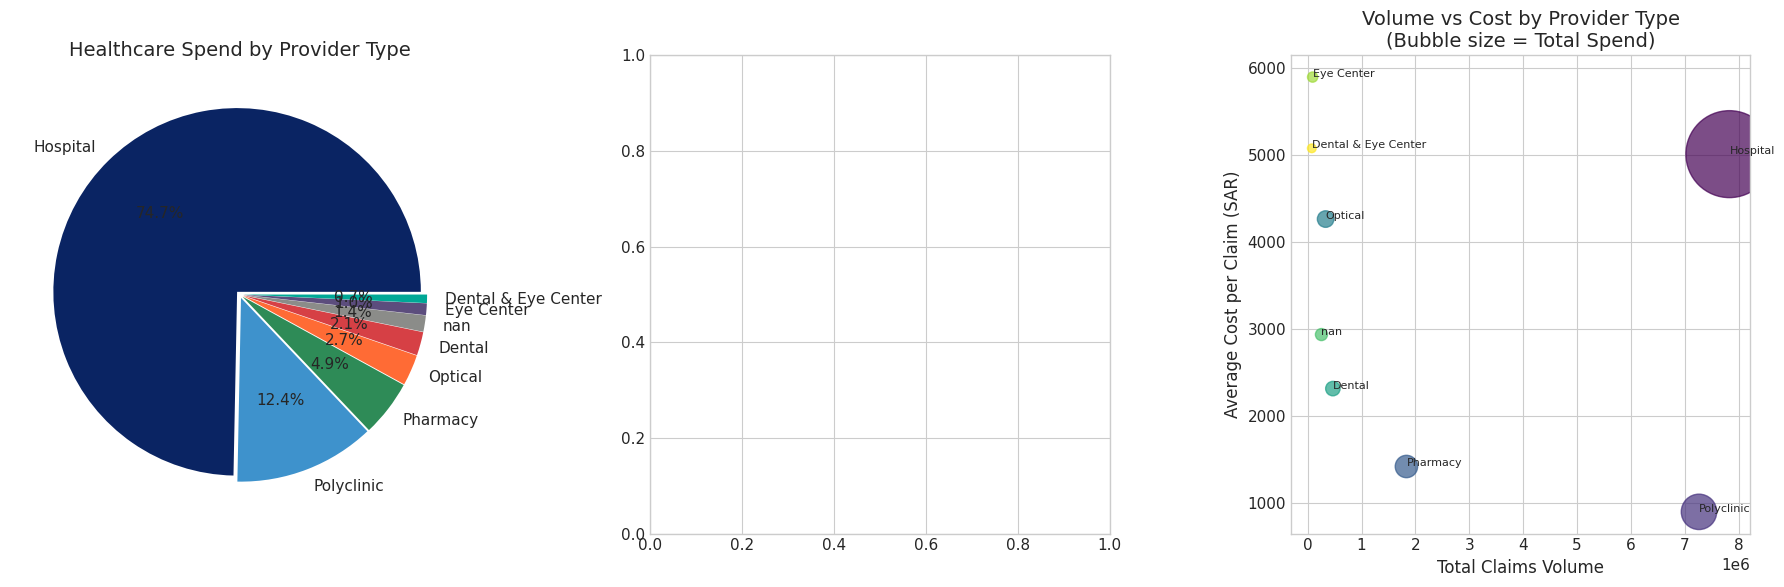

In [ ]:
# Provider analysis visualization
practice_df = practice_analysis.head(8).to_pandas()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Spend distribution by provider type
ax = axes[0]
wedges, texts, autotexts = ax.pie(
    practice_df['Total Billed'],
    labels=practice_df['PROVIDER_PRACTICE'],
    autopct='%1.1f%%',
    colors=CHART_PALETTE[:len(practice_df)],
    explode=[0.02]*len(practice_df)
)
ax.set_title('Healthcare Spend by Provider Type')

# 2. Average cost per claim by type
# ax = axes[1]
# practice_sorted = practice_df.sort_values('Avg Cost per Claim', ascending=True)
# colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(practice_sorted)))
# ax.barh(practice_sorted['PROVIDER_PRACTICE'], practice_sorted['Avg Cost per Claim'], color=colors)
# ax.set_xlabel('Average Cost per Claim (SAR)')
# ax.set_title('Cost Efficiency by Provider Type')

# 3. Volume vs Cost scatter
ax = axes[2]
scatter = ax.scatter(
    practice_df['Total Claims'],
    practice_df['Avg Cost per Claim'],
    s=practice_df['Total Billed']/1e7,
    c=range(len(practice_df)),
    cmap='viridis',
    alpha=0.7
)
for i, row in practice_df.iterrows():
    ax.annotate(row['PROVIDER_PRACTICE'][:10], (row['Total Claims'], row['Avg Cost per Claim']), fontsize=8)
ax.set_xlabel('Total Claims Volume')
ax.set_ylabel('Average Cost per Claim (SAR)')
ax.set_title('Volume vs Cost by Provider Type\n(Bubble size = Total Spend)')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'provider_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [20]:
# Regional analysis
region_analysis = dim_provider.group_by('PROVIDER_REGION').agg([
    pl.col('PROV_CODE').n_unique().alias('Provider Count'),
    pl.col('CLAIM_COUNT').sum().alias('Total Claims'),
    pl.col('TOTAL_BILLED').sum().alias('Total Billed'),
    pl.col('UNIQUE_MEMBERS').sum().alias('Members Served'),
]).with_columns([
    (pl.col('Total Billed') / pl.col('Total Claims')).alias('Avg per Claim'),
    (pl.col('Total Billed') / pl.col('Total Billed').sum() * 100).alias('% of Spend'),
]).filter(pl.col('PROVIDER_REGION').is_not_null()).sort('Total Billed', descending=True)

print('HEALTHCARE SPEND BY REGION')
print('=' * 70)
region_analysis

HEALTHCARE SPEND BY REGION


PROVIDER_REGION,Provider Count,Total Claims,Total Billed,Members Served,Avg per Claim,% of Spend
str,u32,u32,f64,u32,f64,f64
"""Central""",516,6236530,2.0563e10,2187643,3297.196006,38.28344
"""Western""",452,6366214,1.5400e10,2478601,2419.043619,28.671348
"""Eastern""",335,4631687,1.4421e10,1549379,3113.571454,26.848573
"""Southern""",163,550177,1.4527e9,213510,2640.431262,2.704584
"""Overseas""",100,100427,7.3569e8,25142,7325.65455,1.369683
"""Northern""",77,245249,3.8811e8,92163,1582.530771,0.722574


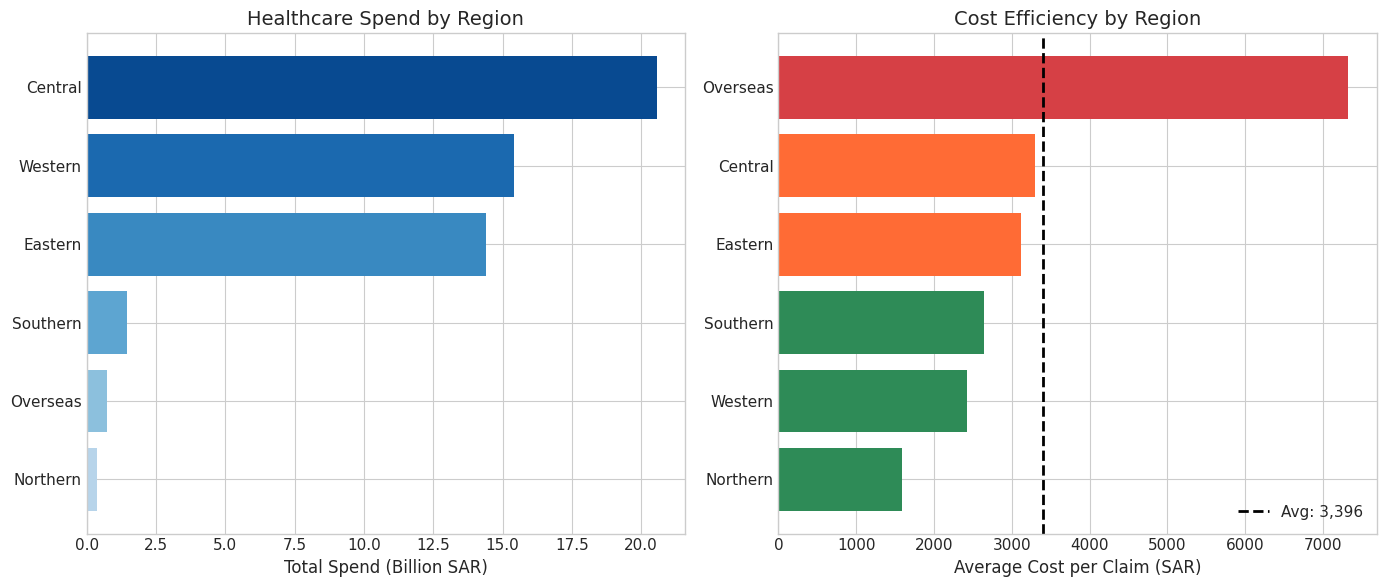

In [21]:
# Regional visualization
region_df = region_analysis.head(10).to_pandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Spend by region
ax = axes[0]
region_sorted = region_df.sort_values('Total Billed', ascending=True)
colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(region_sorted)))
bars = ax.barh(region_sorted['PROVIDER_REGION'], region_sorted['Total Billed']/1e9, color=colors)
ax.set_xlabel('Total Spend (Billion SAR)')
ax.set_title('Healthcare Spend by Region')

# 2. Cost efficiency by region
ax = axes[1]
region_sorted = region_df.sort_values('Avg per Claim', ascending=True)
avg_cost = region_df['Avg per Claim'].mean()
colors = [BUPA_COLORS['success'] if c < avg_cost * 0.9 else BUPA_COLORS['warning'] if c < avg_cost * 1.1 else BUPA_COLORS['danger']
          for c in region_sorted['Avg per Claim']]
bars = ax.barh(region_sorted['PROVIDER_REGION'], region_sorted['Avg per Claim'], color=colors)
ax.axvline(avg_cost, color='black', linestyle='--', linewidth=2, label=f'Avg: {avg_cost:,.0f}')
ax.set_xlabel('Average Cost per Claim (SAR)')
ax.set_title('Cost Efficiency by Region')
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'regional_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Service Experience Analysis

Analyzing call center patterns to understand:
- Service quality indicators
- Complaint patterns
- Experience drivers

In [22]:
# Call category analysis
call_analysis = dim_calls.group_by('CALL_CAT').agg([
    pl.col('CALL_COUNT').sum().alias('Total Calls'),
    pl.col('UNIQUE_CALLERS').sum().alias('Unique Callers'),
    pl.col('CONTRACT_NO').n_unique().alias('Contracts'),
]).with_columns([
    (pl.col('Total Calls') / pl.col('Total Calls').sum() * 100).alias('% of Calls'),
]).sort('Total Calls', descending=True)

print('CALL CENTER INTERACTION CATEGORIES')
print('=' * 70)
call_analysis.head(15)

CALL CENTER INTERACTION CATEGORIES


CALL_CAT,Total Calls,Unique Callers,Contracts,% of Calls
str,u32,u32,u32,f64
"""CC""",5503733,1446511,42561,61.69515
"""SC""",910767,102664,1610,10.209417
"""AC""",599225,92952,2,6.717127
"""VP""",327939,140088,4600,3.676095
"""DS""",251285,82324,8638,2.816827
"""CI""",247483,23955,23926,2.774208
"""MR""",244032,48346,29560,2.735523
"""ME""",206297,102652,591,2.312526
"""CH""",171746,92103,17395,1.92522


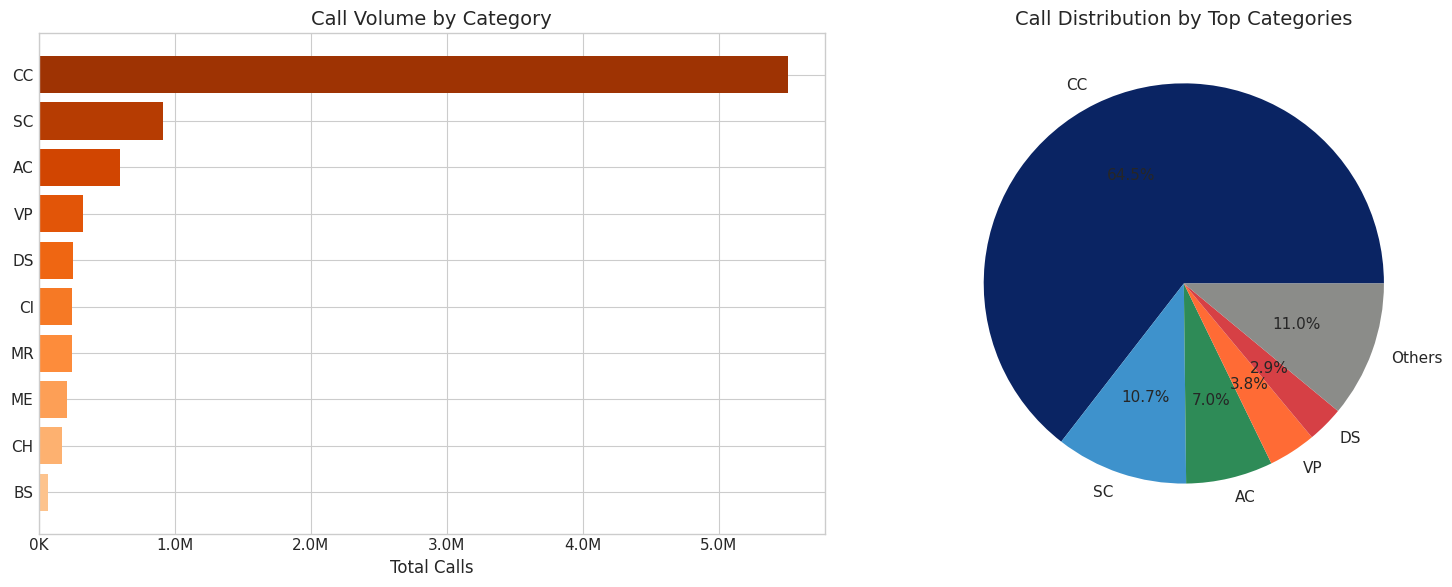

In [23]:
# Call analysis visualization
call_df = call_analysis.filter(pl.col('CALL_CAT').is_not_null()).head(10).to_pandas()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Call volume by category
ax = axes[0]
call_sorted = call_df.sort_values('Total Calls', ascending=True)
colors = plt.cm.Oranges(np.linspace(0.3, 0.9, len(call_sorted)))
bars = ax.barh(call_sorted['CALL_CAT'].str[:30], call_sorted['Total Calls'], color=colors)
ax.set_xlabel('Total Calls')
ax.set_title('Call Volume by Category')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}K'))

# 2. Call distribution pie
ax = axes[1]
top_5_calls = call_df.head(5)
others = pd.DataFrame({'CALL_CAT': ['Others'], 'Total Calls': [call_df.iloc[5:]['Total Calls'].sum()]})
pie_data = pd.concat([top_5_calls[['CALL_CAT', 'Total Calls']], others])
ax.pie(pie_data['Total Calls'], labels=pie_data['CALL_CAT'].str[:20], autopct='%1.1f%%', colors=CHART_PALETTE[:6])
ax.set_title('Call Distribution by Top Categories')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'call_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [24]:
# Calls per member impact on contract health
call_impact = df_contract.with_columns([
    pl.when(pl.col('CALLS_PER_MEMBER') == 0).then(pl.lit('No Calls'))
      .when(pl.col('CALLS_PER_MEMBER') < 0.5).then(pl.lit('Low (<0.5/member)'))
      .when(pl.col('CALLS_PER_MEMBER') < 1.5).then(pl.lit('Medium (0.5-1.5)'))
      .when(pl.col('CALLS_PER_MEMBER') < 3).then(pl.lit('High (1.5-3)'))
      .otherwise(pl.lit('Very High (3+)')).alias('CALL_INTENSITY'),
]).group_by('CALL_INTENSITY').agg([
    pl.len().alias('Contract Count'),
    pl.col('LOSS_RATIO').mean().alias('Avg Loss Ratio'),
    pl.col('UTILIZATION_RATE').mean().alias('Avg Utilization'),
    pl.col('TOTAL_MEMBERS').sum().alias('Total Members'),
]).sort('Contract Count', descending=True)

print('CALL INTENSITY VS CONTRACT PERFORMANCE')
print('=' * 70)
print('Higher call intensity may indicate service issues or complex member needs')
call_impact

CALL INTENSITY VS CONTRACT PERFORMANCE
Higher call intensity may indicate service issues or complex member needs


CALL_INTENSITY,Contract Count,Avg Loss Ratio,Avg Utilization,Total Members
str,u32,f64,f64,u32
"""No Calls""",99912,100.399398,0.014316,104247
"""Medium (0.5-1.5)""",12847,6943.616551,0.57138,1786001
"""High (1.5-3)""",8674,12011.526497,0.650146,1518311
"""Very High (3+)""",8406,26092.895729,0.788834,434369
"""Low (<0.5/member)""",3865,3512.006435,0.493669,358539


---
## 6. Cost Driver Analysis

Identifying the key factors that drive high costs and poor loss ratios.

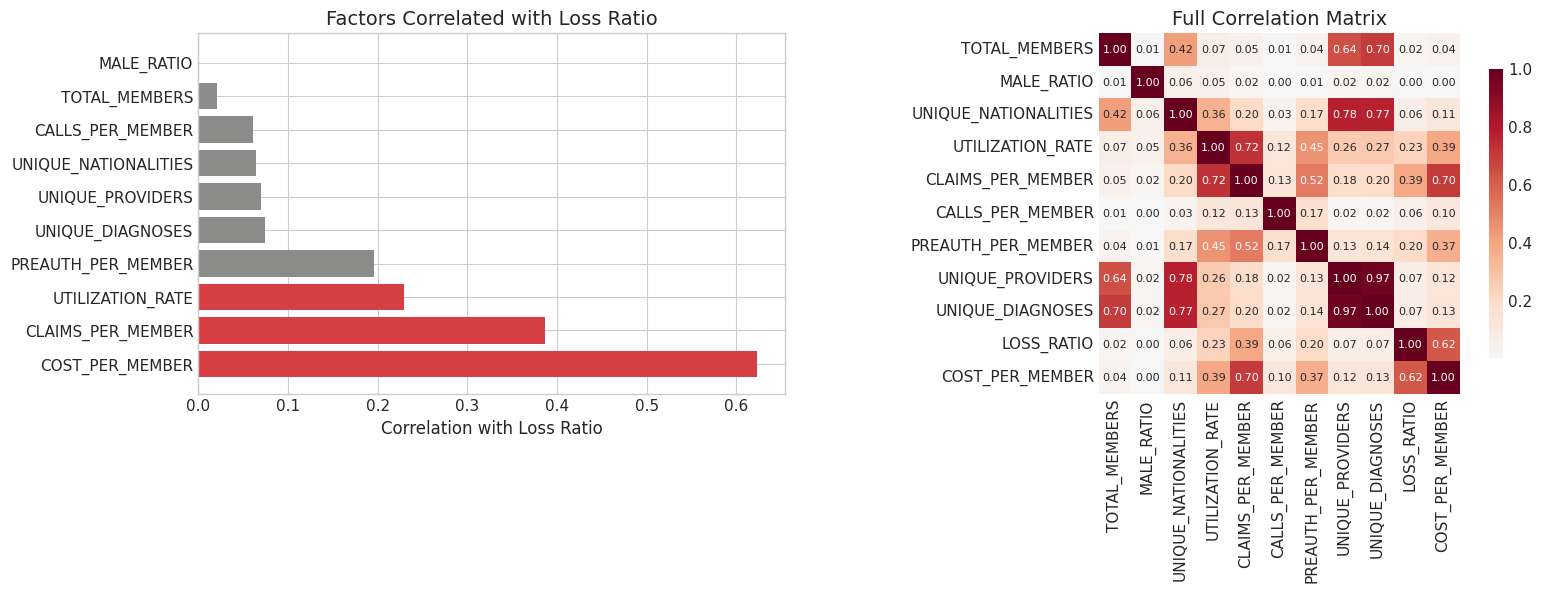


TOP COST DRIVERS (Positive = increases loss ratio):
COST_PER_MEMBER       0.623439
CLAIMS_PER_MEMBER     0.386690
UTILIZATION_RATE      0.229215
PREAUTH_PER_MEMBER    0.195581
UNIQUE_DIAGNOSES      0.073933
Name: LOSS_RATIO, dtype: float64


In [25]:
# Correlation analysis for cost drivers
cost_features = [
    'TOTAL_MEMBERS', 'MALE_RATIO', 'UNIQUE_NATIONALITIES', 'UTILIZATION_RATE',
    'CLAIMS_PER_MEMBER', 'CALLS_PER_MEMBER', 'PREAUTH_PER_MEMBER',
    'UNIQUE_PROVIDERS', 'UNIQUE_DIAGNOSES', 'LOSS_RATIO', 'COST_PER_MEMBER'
]

# Filter to available columns
available_features = [f for f in cost_features if f in df_contract.columns]
corr_df = df_contract.select(available_features).to_pandas()
corr_matrix = corr_df.corr()

# Plot correlation with LOSS_RATIO
loss_corr = corr_matrix['LOSS_RATIO'].drop('LOSS_RATIO').sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Correlation bar chart
ax = axes[0]
colors = [BUPA_COLORS['danger'] if c > 0.2 else BUPA_COLORS['success'] if c < -0.1 else BUPA_COLORS['neutral']
          for c in loss_corr.values]
bars = ax.barh(loss_corr.index, loss_corr.values, color=colors)
ax.axvline(0, color='black', linewidth=0.5)
ax.set_xlabel('Correlation with Loss Ratio')
ax.set_title('Factors Correlated with Loss Ratio')

# 2. Full correlation heatmap
ax = axes[1]
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f', 
            square=True, ax=ax, cbar_kws={'shrink': 0.8}, annot_kws={'fontsize': 8})
ax.set_title('Full Correlation Matrix')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'cost_drivers.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nTOP COST DRIVERS (Positive = increases loss ratio):')
print(loss_corr.head(5))

In [26]:
# High-cost contract profile
high_cost = df_contract.filter(pl.col('LOSS_RATIO') > 1.3)
low_cost = df_contract.filter(pl.col('LOSS_RATIO') < 0.6)

comparison_metrics = ['TOTAL_MEMBERS', 'UTILIZATION_RATE', 'CLAIMS_PER_MEMBER', 
                      'CALLS_PER_MEMBER', 'MALE_RATIO', 'UNIQUE_NATIONALITIES']

high_profile = high_cost.select([pl.col(m).mean().alias(m) for m in comparison_metrics]).to_pandas().T
high_profile.columns = ['High Risk']

low_profile = low_cost.select([pl.col(m).mean().alias(m) for m in comparison_metrics]).to_pandas().T
low_profile.columns = ['Low Risk']

comparison = pd.concat([high_profile, low_profile], axis=1)
comparison['Difference'] = comparison['High Risk'] - comparison['Low Risk']
comparison['% Diff'] = (comparison['Difference'] / comparison['Low Risk'] * 100).round(1)

print('HIGH-RISK vs LOW-RISK CONTRACT PROFILE')
print('=' * 70)
print(comparison)

HIGH-RISK vs LOW-RISK CONTRACT PROFILE
                       High Risk  Low Risk  Difference    % Diff
TOTAL_MEMBERS         130.059850  1.217044  128.842806   10586.5
UTILIZATION_RATE        0.731547  0.000183    0.731364  398847.4
CLAIMS_PER_MEMBER      23.086782  0.005004   23.081778  461281.3
CALLS_PER_MEMBER        2.619116  0.169432    2.449685    1445.8
MALE_RATIO              0.668287  0.577477    0.090810      15.7
UNIQUE_NATIONALITIES    5.622906  1.028821    4.594086     446.5


---
## 7. Diagnosis Pattern Analysis

Understanding the most costly diagnoses and health patterns.

In [27]:
# Top diagnoses by cost
diagnosis_summary = dim_diagnosis.group_by('DIAG_CODE').agg([
    pl.col('OCCURRENCE_COUNT').sum().alias('Total Occurrences'),
    pl.col('TOTAL_BILLED').sum().alias('Total Cost'),
    pl.col('UNIQUE_MEMBERS').sum().alias('Affected Members'),
    pl.col('CONTRACT_NO').n_unique().alias('Contracts'),
]).with_columns([
    (pl.col('Total Cost') / pl.col('Total Occurrences')).alias('Avg Cost per Occurrence'),
    (pl.col('Total Cost') / pl.col('Affected Members')).alias('Avg Cost per Member'),
]).filter(
    (pl.col('DIAG_CODE').is_not_null()) & (pl.col('Total Occurrences') > 100)
).sort('Total Cost', descending=True)

print('TOP 20 DIAGNOSES BY TOTAL COST')
print('=' * 70)
diagnosis_summary.head(20)

TOP 20 DIAGNOSES BY TOTAL COST


DIAG_CODE,Total Occurrences,Total Cost,Affected Members,Contracts,Avg Cost per Occurrence,Avg Cost per Member
str,u32,f64,u32,u32,f64,f64
"""K02""",2288749,1.7746e9,493185,20884,775.377666,3598.335022
"""E11""",2674153,1.7485e9,169631,15290,653.848057,10307.607347
"""H52""",676744,1.2768e9,318689,14871,1886.642551,4006.332275
"""I10""",1909936,9.3309e8,158840,14900,488.543218,5874.378486
"""R52.9""",887270,7.7632e8,101001,7406,874.951749,7686.245066
"""J06.9""",3668320,7.2035e8,456894,19462,196.370507,1576.623589
"""O82""",118139,6.5138e8,11518,3816,5513.699983,56553.481704
"""R10.4""",824022,4.7274e8,100128,10531,573.697057,4721.346641
…,…,…,…,…,…,…


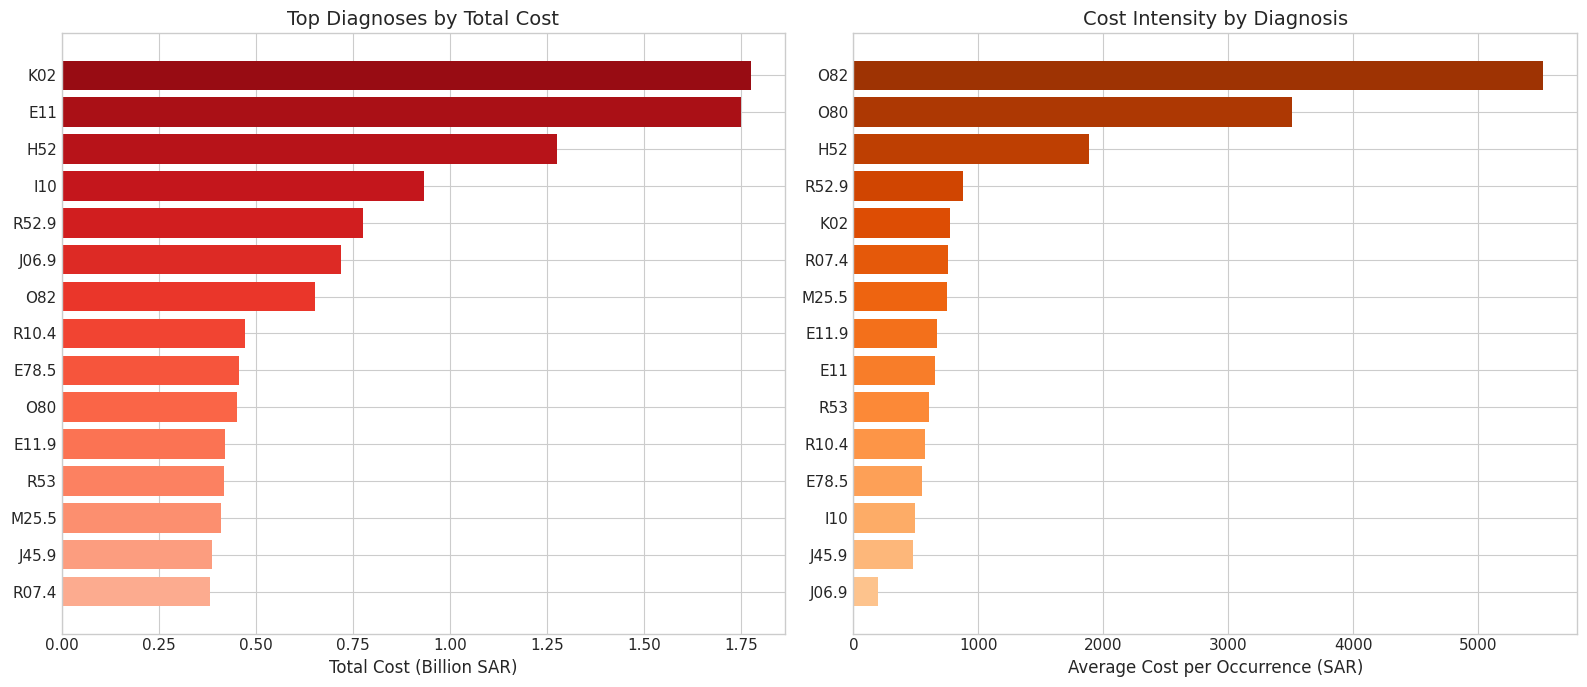

In [28]:
# Diagnosis visualization
diag_df = diagnosis_summary.head(15).to_pandas()

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 1. Total cost by diagnosis
ax = axes[0]
diag_sorted = diag_df.sort_values('Total Cost', ascending=True)
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(diag_sorted)))
bars = ax.barh(diag_sorted['DIAG_CODE'], diag_sorted['Total Cost']/1e9, color=colors)
ax.set_xlabel('Total Cost (Billion SAR)')
ax.set_title('Top Diagnoses by Total Cost')

# 2. Cost per occurrence (unit cost analysis)
ax = axes[1]
diag_sorted = diag_df.sort_values('Avg Cost per Occurrence', ascending=True)
colors = plt.cm.Oranges(np.linspace(0.3, 0.9, len(diag_sorted)))
bars = ax.barh(diag_sorted['DIAG_CODE'], diag_sorted['Avg Cost per Occurrence'], color=colors)
ax.set_xlabel('Average Cost per Occurrence (SAR)')
ax.set_title('Cost Intensity by Diagnosis')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'diagnosis_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 8. Strategic Recommendations Framework

Based on the data analysis, here are actionable recommendations segmented by risk tier.

In [29]:
# Create action-oriented segments
df_recommendations = df_contract.with_columns([
    # Retention priority score (higher = more at risk)
    (pl.col('LOSS_RATIO') * 30 + 
     pl.col('CALLS_PER_MEMBER') * 10 + 
     (1 - pl.col('UTILIZATION_RATE')) * 5).alias('RETENTION_RISK_SCORE'),
    
    # Value score (higher = more valuable)
    (pl.col('TOTAL_WRITTEN_PREMIUM') / pl.col('TOTAL_WRITTEN_PREMIUM').max() * 50 +
     pl.col('TOTAL_MEMBERS') / pl.col('TOTAL_MEMBERS').max() * 30 +
     (1 - pl.col('LOSS_RATIO').clip(0, 2) / 2) * 20).alias('VALUE_SCORE'),
]).with_columns([
    # Strategic action category
    pl.when((pl.col('LOSS_RATIO') > 1.0) & (pl.col('VALUE_SCORE') > 50))
      .then(pl.lit('HIGH PRIORITY - Intervention Required'))
      .when((pl.col('LOSS_RATIO') > 1.0) & (pl.col('VALUE_SCORE') <= 50))
      .then(pl.lit('REVIEW - Consider Repricing'))
      .when((pl.col('LOSS_RATIO') < 0.6) & (pl.col('VALUE_SCORE') > 50))
      .then(pl.lit('STAR CLIENTS - Retain & Expand'))
      .when((pl.col('LOSS_RATIO') < 0.85))
      .then(pl.lit('HEALTHY - Maintain Relationship'))
      .otherwise(pl.lit('MONITOR - Standard Management')).alias('ACTION_CATEGORY'),
])

# Action category summary
action_summary = df_recommendations.group_by('ACTION_CATEGORY').agg([
    pl.len().alias('Contract Count'),
    pl.col('TOTAL_MEMBERS').sum().alias('Total Members'),
    pl.col('TOTAL_WRITTEN_PREMIUM').sum().alias('Total Premium'),
    pl.col('LOSS_RATIO').mean().alias('Avg Loss Ratio'),
]).with_columns([
    (pl.col('Total Premium') / pl.col('Total Premium').sum() * 100).alias('% of Portfolio'),
]).sort('Total Premium', descending=True)

print('STRATEGIC ACTION SEGMENTATION')
print('=' * 70)
action_summary

STRATEGIC ACTION SEGMENTATION


ACTION_CATEGORY,Contract Count,Total Members,Total Premium,Avg Loss Ratio,% of Portfolio
str,u32,u32,f64,f64,f64
"""REVIEW - Consider Repricing""",31346,3950409,6.0717e10,13918.112447,87.506216
"""HIGH PRIORITY - Intervention Required""",1,126485,8.4357e9,58283.46034,12.157648
"""HEALTHY - Maintain Relationship""",102357,124573,2.3323e8,-0.009013,0.336136


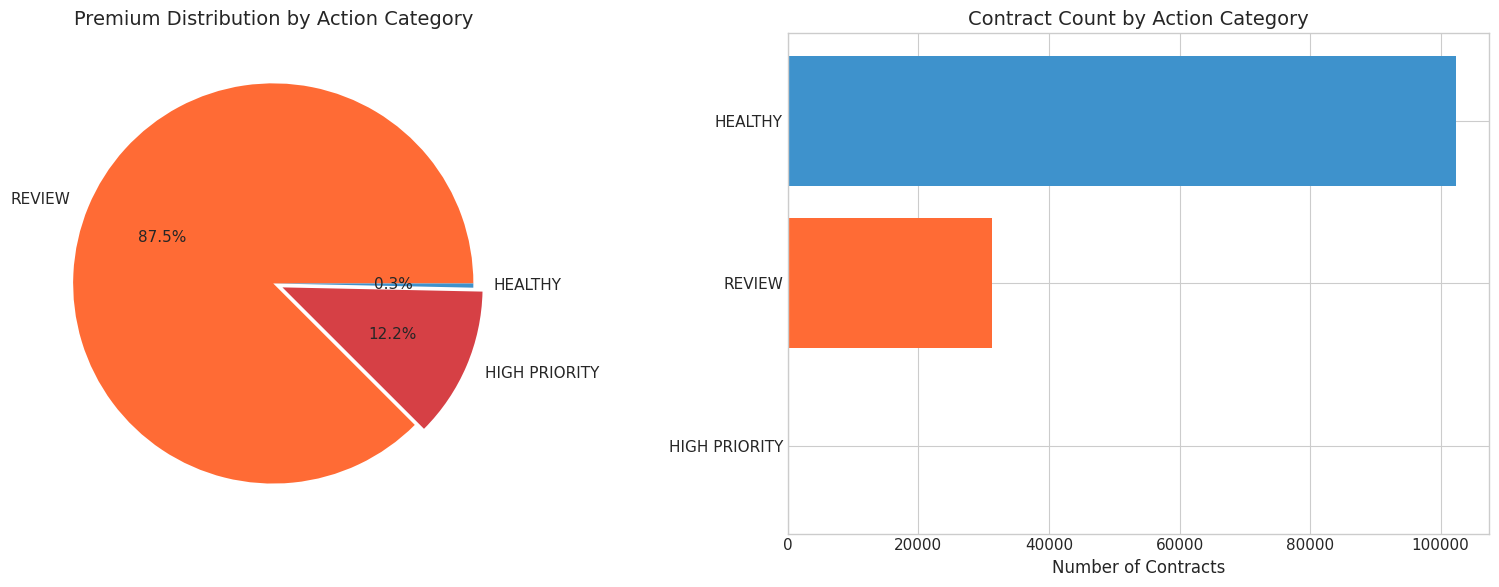

In [30]:
# Recommendation visualization
action_df = action_summary.to_pandas()

action_colors = {
    'HIGH PRIORITY - Intervention Required': BUPA_COLORS['danger'],
    'REVIEW - Consider Repricing': BUPA_COLORS['warning'],
    'STAR CLIENTS - Retain & Expand': BUPA_COLORS['success'],
    'HEALTHY - Maintain Relationship': BUPA_COLORS['secondary'],
    'MONITOR - Standard Management': BUPA_COLORS['neutral'],
}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Premium by action category
ax = axes[0]
colors = [action_colors.get(cat, BUPA_COLORS['neutral']) for cat in action_df['ACTION_CATEGORY']]
wedges, texts, autotexts = ax.pie(
    action_df['Total Premium'],
    labels=[cat.split(' - ')[0] for cat in action_df['ACTION_CATEGORY']],
    autopct='%1.1f%%',
    colors=colors,
    explode=[0.05 if 'HIGH' in cat else 0 for cat in action_df['ACTION_CATEGORY']]
)
ax.set_title('Premium Distribution by Action Category')

# 2. Contracts by category
ax = axes[1]
action_sorted = action_df.sort_values('Contract Count', ascending=True)
colors = [action_colors.get(cat, BUPA_COLORS['neutral']) for cat in action_sorted['ACTION_CATEGORY']]
bars = ax.barh([cat.split(' - ')[0] for cat in action_sorted['ACTION_CATEGORY']], 
               action_sorted['Contract Count'], color=colors)
ax.set_xlabel('Number of Contracts')
ax.set_title('Contract Count by Action Category')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'recommendations.png', dpi=150, bbox_inches='tight')
plt.show()

In [31]:
# Detailed recommendations for each segment
recommendations = {
    'HIGH PRIORITY - Intervention Required': {
        'Description': 'High-value contracts with unsustainable loss ratios',
        'Actions': [
            '1. Immediate: Schedule executive relationship review meeting',
            '2. Short-term: Deploy dedicated care managers for chronic disease members',
            '3. Mid-term: Implement wellness programs targeting top cost drivers',
            '4. Analytics: Identify high-cost members for personalized intervention',
            '5. Negotiate: Discuss network steering to cost-effective providers',
        ],
        'KPIs': 'Target 15% loss ratio reduction within 12 months'
    },
    'REVIEW - Consider Repricing': {
        'Description': 'Lower-value contracts with poor performance',
        'Actions': [
            '1. Analyze: Deep dive into cost drivers and utilization patterns',
            '2. Pricing: Prepare adjusted renewal pricing with risk load',
            '3. Benefits: Consider benefit design changes (copays, deductibles)',
            '4. Network: Evaluate restricting to narrow network',
            '5. Decision: Prepare walk-away scenario if unprofitable',
        ],
        'KPIs': 'Achieve minimum 85% target loss ratio at renewal'
    },
    'STAR CLIENTS - Retain & Expand': {
        'Description': 'High-value, profitable accounts - protect these!',
        'Actions': [
            '1. Relationship: Assign senior account manager',
            '2. Service: Offer premium service SLAs',
            '3. Upsell: Propose additional coverage options',
            '4. Wellness: Offer complimentary wellness programs',
            '5. Early renewal: Lock in multi-year agreements',
        ],
        'KPIs': 'Achieve 95%+ retention rate, 10% premium growth'
    },
    'HEALTHY - Maintain Relationship': {
        'Description': 'Profitable contracts performing within targets',
        'Actions': [
            '1. Monitor: Regular performance dashboards',
            '2. Engage: Quarterly business reviews',
            '3. Wellness: Standard wellness communication',
            '4. Renewal: Standard renewal process',
            '5. Upsell: Opportunistic cross-sell attempts',
        ],
        'KPIs': 'Maintain loss ratio below 85%, 90%+ retention'
    },
    'MONITOR - Standard Management': {
        'Description': 'Average performers requiring standard attention',
        'Actions': [
            '1. Track: Automated performance monitoring',
            '2. Alert: Set triggers for deteriorating metrics',
            '3. Communication: Regular health tips and updates',
            '4. Support: Reactive customer service model',
            '5. Review: Annual performance assessment',
        ],
        'KPIs': 'Keep loss ratio trending toward target'
    }
}

print('STRATEGIC RECOMMENDATIONS BY SEGMENT')
print('=' * 70)
for segment, details in recommendations.items():
    print(f'\n{segment}')
    print('-' * 50)
    print(f"Description: {details['Description']}")
    print('\nRecommended Actions:')
    for action in details['Actions']:
        print(f'  {action}')
    print(f"\nTarget KPI: {details['KPIs']}")

STRATEGIC RECOMMENDATIONS BY SEGMENT

HIGH PRIORITY - Intervention Required
--------------------------------------------------
Description: High-value contracts with unsustainable loss ratios

Recommended Actions:
  1. Immediate: Schedule executive relationship review meeting
  2. Short-term: Deploy dedicated care managers for chronic disease members
  3. Mid-term: Implement wellness programs targeting top cost drivers
  4. Analytics: Identify high-cost members for personalized intervention
  5. Negotiate: Discuss network steering to cost-effective providers

Target KPI: Target 15% loss ratio reduction within 12 months

REVIEW - Consider Repricing
--------------------------------------------------
Description: Lower-value contracts with poor performance

Recommended Actions:
  1. Analyze: Deep dive into cost drivers and utilization patterns
  2. Pricing: Prepare adjusted renewal pricing with risk load
  3. Benefits: Consider benefit design changes (copays, deductibles)
  4. Network: Ev

---
## 9. Executive Summary Dashboard Data

Preparing summary metrics for the final presentation.

In [32]:
# Executive summary metrics
exec_summary = {
    'Portfolio Overview': {
        'Total Contracts': f"{df_contract.height:,}",
        'Total Members': f"{df_contract['TOTAL_MEMBERS'].sum():,.0f}",
        'Total Premium': f"{df_contract['TOTAL_WRITTEN_PREMIUM'].sum()/1e9:.2f}B SAR",
        'Total Claims': f"{df_contract['TOTAL_NET_BILLED'].sum()/1e9:.2f}B SAR",
        'Portfolio Loss Ratio': f"{(df_contract['TOTAL_NET_BILLED'].sum() / df_contract['TOTAL_EARNED'].sum()):.1%}",
    },
    'Risk Distribution': {
        'Low Risk Contracts': f"{df_contract.filter(pl.col('RISK_TIER') == 'Low Risk').height:,}",
        'High Risk Contracts': f"{df_contract.filter(pl.col('RISK_TIER').is_in(['Elevated', 'High Risk'])).height:,}",
        'Premium at Risk': f"{df_contract.filter(pl.col('LOSS_RATIO') > 1.0)['TOTAL_WRITTEN_PREMIUM'].sum()/1e9:.2f}B SAR",
    },
    'Key Opportunities': {
        'Star Clients (Upsell)': f"{df_recommendations.filter(pl.col('ACTION_CATEGORY').str.contains('STAR')).height:,}",
        'Intervention Required': f"{df_recommendations.filter(pl.col('ACTION_CATEGORY').str.contains('HIGH PRIORITY')).height:,}",
        'Repricing Candidates': f"{df_recommendations.filter(pl.col('ACTION_CATEGORY').str.contains('REVIEW')).height:,}",
    }
}

print('EXECUTIVE SUMMARY')
print('=' * 70)
for section, metrics in exec_summary.items():
    print(f'\n{section}:')
    for metric, value in metrics.items():
        print(f'  - {metric}: {value}')

EXECUTIVE SUMMARY

Portfolio Overview:
  - Total Contracts: 133,704
  - Total Members: 4,201,467
  - Total Premium: 69.39B SAR
  - Total Claims: 53.67B SAR
  - Portfolio Loss Ratio: 1549530.4%

Risk Distribution:
  - Low Risk Contracts: 102,357
  - High Risk Contracts: 31,347
  - Premium at Risk: 69.15B SAR

Key Opportunities:
  - Star Clients (Upsell): 0
  - Intervention Required: 1
  - Repricing Candidates: 31,346


In [33]:
# Save enhanced contract dataset with recommendations
df_recommendations.write_parquet(OUTPUT_DIR / 'contract_recommendations.parquet')
print(f'Enhanced contract data saved to: {OUTPUT_DIR / "contract_recommendations.parquet"}')

# Save action summary for dashboard
action_summary.write_parquet(OUTPUT_DIR / 'action_summary.parquet')
print(f'Action summary saved to: {OUTPUT_DIR / "action_summary.parquet"}')

# List all output files
print('\nAll output files:')
for f in sorted(OUTPUT_DIR.glob('*')):
    if f.is_file():
        size_mb = f.stat().st_size / 1e6
        print(f'  {f.name:40} {size_mb:>8.2f} MB')

Enhanced contract data saved to: /volume/data/insights/contract_recommendations.parquet
Action summary saved to: /volume/data/insights/action_summary.parquet

All output files:
  action_summary.parquet                       0.00 MB
  call_analysis.png                            0.09 MB
  contract_recommendations.parquet             7.72 MB
  contract_size_analysis.png                   0.13 MB
  cost_drivers.png                             0.26 MB
  diagnosis_analysis.png                       0.09 MB
  gender_analysis.png                          0.10 MB
  nationality_analysis.png                     0.13 MB
  provider_analysis.png                        0.17 MB
  recommendations.png                          0.07 MB
  regional_analysis.png                        0.07 MB
  risk_tier_analysis.png                       0.07 MB


---
## 10. Key Insights Summary

### Portfolio Health
- Significant portion of premium is concentrated in high-risk contracts
- Enterprise accounts drive most premium but require careful monitoring
- Loss ratio distribution shows opportunities for both retention and repricing

### Demographic Insights
- Nationality-based cost variations suggest opportunities for targeted wellness programs
- Gender mix impacts utilization patterns and should inform risk assessment
- Multi-national workforces may have different healthcare needs

### Provider Patterns
- Hospital costs dominate spend - network management is critical
- Regional variations in cost efficiency suggest network optimization opportunities
- Provider steering could reduce costs without impacting care quality

### Service Experience
- Call patterns indicate potential service pain points
- High call intensity correlates with higher costs - proactive communication may help
- Complaints are early warning indicators for retention risk

### Strategic Priorities
1. **Protect Star Clients** - Lock in profitable accounts with enhanced service
2. **Intervene Early** - Deploy care managers for high-risk accounts
3. **Optimize Pricing** - Adjust renewal pricing based on risk profile
4. **Network Management** - Steer to cost-effective, high-quality providers
5. **Wellness Investment** - Target top cost drivers with prevention programs

In [ ]:
print('Business Insights Analysis Complete!')
print('=' * 70)
print('\nNext Steps:')
print('1. Build IVI scoring model using contract_recommendations.parquet')
print('2. Create interactive dashboard for stakeholders')
print('3. Develop retention prediction model')
print('4. Design intervention tracking system')